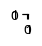

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150

sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm.auto import tqdm
from datetime import datetime as dt
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180
# Load models together
%load_ext autoreload
%autoreload 2
    
from src.torch_utils import load_model_full
from src.utils import get_class_initcode_keys
from torch.utils.data import SequentialSampler
from src.datasets import *
from src.models import *
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.sim_utils import make_dist_matrix
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE, TwoStageVAECLF
from src.conv_models import CNNVAE, TwoStageCNNVAECLF
from src.metrics import reconstruction_accuracy, compute_cosine_distance
from src.cluster_utils import *
from src.networkx_utils import *

# init

In [2]:
import csv
def get_metadata(filename):
    # Initialize a dictionary to hold the header information
    metadatares = {'filename':os.path.basename(filename)}
    metadatares['relpath']=filename
    # Read the CSV file
    with open(filename, mode='r') as file:
        reader = csv.reader(file)
        # Read the first line which contains the metadata
        metadata_line = next(reader)[0]
        # Convert the metadata line to a dictionary
        metadata = eval(metadata_line)
    metadatares.update(metadata)
    return metadatares
    
def read_ots_data(filename):
    metadata = get_metadata(filename)
    df = pd.read_csv(filename, skiprows=1)
    df = df[[c for c in df.columns if ('aa' in c.lower() and 'cdr' in c.lower()) or 'call' in c.lower()]]
    df.columns = [x.replace('cdr','').replace('_aa_','').replace('beta','B').replace('alpha','A')[::-1] if 'cdr' in x else x for x in df.columns]
    df.columns = df.columns.str.replace('_call','')
    df['Link']=metadata['Link']
    df['Disease']=metadata['Disease']
    df['CancerType']=metadata['CancerType']
    df['Source']=metadata['TSource']
    df['Subject']=metadata['Subject']
    return df, metadata


def plot_prune_heatmap(values, threshold, title, 
                       filename=None, outdir='../output/240618_NestedKCV_CNNVAE/notebook_figs/',
                       sorted_dm=None,
                       cmap='vlag', color='g', addline=True):
    # prune and plot the heatmap
    f,ax = plt.subplots(1,2, figsize=(16,16), width_ratios=(16.5/17, 0.5/17))
    ax = ax.ravel()
    ax, cbar_ax = ax[0], ax[1]
    pruned = values.copy()
    mask = (pruned<=threshold).astype(int)
    pruned = pruned * mask
    sns.heatmap(pruned, ax=ax, square=True, vmin=0, vmax=values.max(), cbar_ax=cbar_ax, cmap=cmap)
    # Set up custom tickmarks if available
    if sorted_dm is not None:
        pepmap = sorted_dm.groupby('peptide').agg(count=('raw_index','count'))
        pepmap['idx']=pepmap['count'].cumsum()
        pepmap['tick']=pepmap['idx']-pepmap['count'].iloc[0]+3
        tickmarks = pepmap['tick'].to_dict() 
        idxs = pepmap['idx'].to_dict()
        ax.set_xticks(list(tickmarks.values()))
        ax.set_yticks(list(tickmarks.values()))
        ax.set_xticklabels(list(tickmarks.keys()), ha='center', fontweight='semibold', fontsize=15)
        ax.set_yticklabels(list(tickmarks.keys()), va='center', fontweight='semibold', fontsize=15)
    if addline and sorted_dm is not None:
        for k,v in idxs.items():
            ax.axhline(v, ls='--', lw=.9, c=color)
            ax.axvline(v, ls='--', lw=.9, c=color)
    # Rotate the tick labels for better readability (optional)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.set_title(title, fontweight='semibold', fontsize=17)
    f.tight_layout()
    if filename is not None:
        f.savefig(f'{outdir}{filename}.png', dpi=150, bbox_inches='tight')
    plt.close()
    del f, ax

def do_all(filename, model, noplot=False, unique=False, outdir='../output/240820_HumanRepertoires/'):
    df, metadata = read_ots_data(filename)
    df['tcr'] = df[['A1','A2','A3','B1','B2','B3']].sum(axis=1)
    if unique:
        df.drop_duplicates(subset=['tcr'], inplace=True)
    metadata['n_seq'] = len(df)
    metadata['n_unique'] = len(df['tcr'].unique())
    pd.DataFrame(metadata, index=[0]).to_csv(f"{outdir}metadata/{metadata['Run']}_metadata.txt", index=False)
    if noplot:
        return 0
    else:
            
        if len(glob.glob(f'{outdir}heatmaps/*{metadata["Run"]}*'))>0:
            return 0
    
        latent_df = get_latent_df(model, df)
        latent_df['index_col'] = [f'seq_{i:04}' for i in range(len(latent_df))]
        _, values_array, _, _, _, _ = get_distances_labels_from_latent(latent_df, 
                                                                       label_col='Disease', 
                                                                       index_col='index_col',
                                                                       rest_cols=['Disease','CancerType','Source'],
                                                                       low_memory=True)
        
        latent_df['tcr'] = latent_df[['A1','A2','A3','B1','B2','B3']].sum(axis=1)
        n_seq=len(latent_df)
        n_unique=len(latent_df['tcr'].unique())
        plot_prune_heatmap(values_array, threshold=10, title=f"{metadata['Run']}, n_seq={n_seq}, n_unique={n_unique}", 
                           filename=f'{metadata["Run"]}_n-{n_seq}_unique-{n_unique}',
                           outdir=f'{outdir}heatmaps/', addline=False, sorted_dm=None)
        print(metadata['Run'], '\t', n_seq, '\t', n_unique)
        del latent_df
    # latent_df.groupby(['tcr']).agg(count=('B1','count')).sort_values('count',ascending=False)

In [7]:
def read_ots_unique(filename):
    df, metadata = read_ots_data(filename)
    df['tcr'] = df[['A1','A2','A3','B1','B2','B3']].sum(axis=1)
    metadata['n_seq'] = len(df)
    metadata['unique'] = len(df.tcr.unique())
    counts = df.groupby('tcr').agg(count=('B3','count'))
    df = df.drop_duplicates(subset=['tcr'])
    df = df.set_index('tcr').merge(counts,left_index=True,right_index=True).reset_index()
    df['Run']=metadata['Run']
    return df, metadata

In [3]:
meta_df = pd.read_csv('../data/OTS/human/METADATA.txt')
meta_df.groupby(['Link','Author']).agg(disease=('Disease','unique'),
                                      n_repertoires=('Disease','count'),
                                      mean_size=('Sequences', 'mean'),
                                      mean_unique=('n_unique','mean'))

,,disease,n_repertoires,mean_size,mean_unique
Link,Author,,,,
https://pubmed.ncbi.nlm.nih.gov/33478949/,Kusnadi et al. 2021,[covid],15,4657.133333,734.266667
https://pubmed.ncbi.nlm.nih.gov/34156975/,"Peng et al., 2021",[herpes_simplex_virus_type_2],4,1324.250000,681.250000
https://pubmed.ncbi.nlm.nih.gov/34793243/,Francis et al. 2021,[covid],95,1655.589474,821.357895
https://pubmed.ncbi.nlm.nih.gov/36516854/,Yu et al. 2022,[cmv],6,2545.833333,733.500000
https://pubmed.ncbi.nlm.nih.gov/37580605/,Garner et al.,[healthy],96,5587.364583,1663.104167
https://www.nature.com/articles/s41590-022-01367-z,Xu et al. 2023,[covid],8,4370.750000,3346.875000
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10201342/,Eberhardt et al. 2021,[cancer],51,1234.333333,191.705882


# re-make francis healthy data with low healthy counts

# Do run merging Covid (Francis) and Healthy (Garner) studies

## save with low counts

<Axes: title={'center': 'Garner Healthy'}, ylabel='Frequency'>

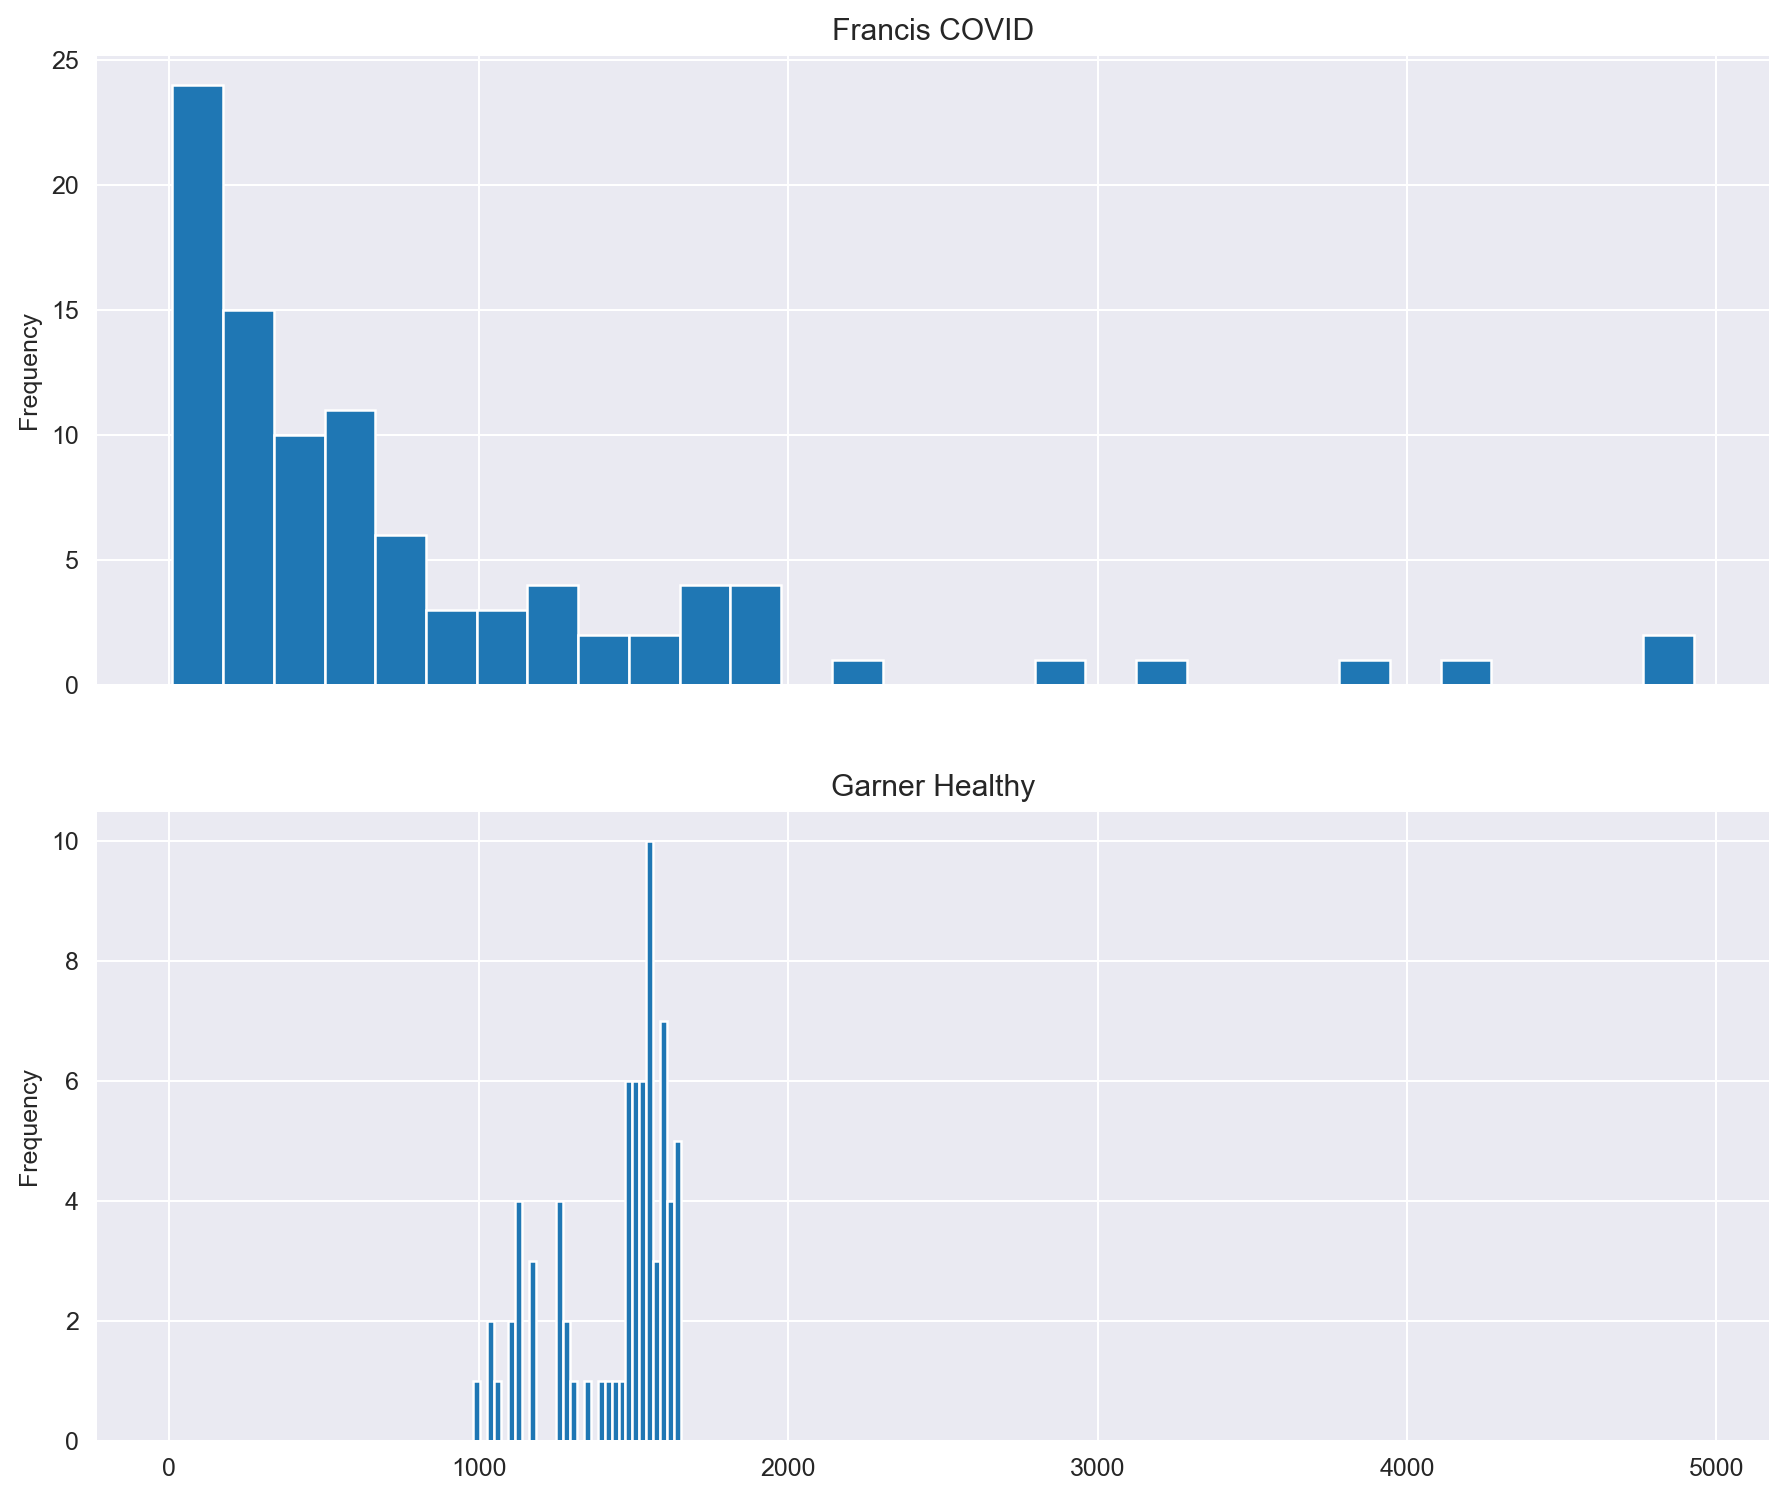

In [9]:
garner_pbmc = meta_df.query('Author.str.contains("Garner")').query('TSource=="pbmc"')
francis_pbmc = meta_df.query('Author.str.contains("Franc")')
f,a = plt.subplots(2,1, figsize=(12,10), sharex=True)
ax = a.ravel()
francis_pbmc.n_unique.plot(kind='hist', bins=30, ax = ax[0], title='Francis COVID')
garner_pbmc.n_unique.plot(kind='hist', bins=30, ax = ax[1], title='Garner Healthy')

In [16]:
%mkdir ../data/OTS/subsampled_covid_healthy_lowcount/
garner_3 = pd.read_csv('../data/OTS/garner_merged/garner_merged_41_42_43.csv').query('mean_count<2')
garner_3.query('mean_count==1')

,tcr,v_beta,d_beta,j_beta,B1,B2,B3,v_alpha,d_alpha,j_alpha,...,CancerType,Source,Subject,count,Run,duplicated,n_dupes,mean_count,max_count,index_col
0,ATGYPSATKADDKAFMDTGRRALTSGHTAFQGTGAASSQVGGGTDTQY,TRBV7-3*01,TRBD2*01,TRBJ2-3*01,SGHTA,FQGTGA,ASSQVGGGTDTQY,TRAV9-2*01,NaN,TRAJ5*01,...,none,pbmc,4.1_4.2_4.3,1,SRR25409126,True,6.0,1.0,1.0,garner_00000
2,ATGYPSATKADDKALCLYGGATNKLIMNHNYSVGAGIASSPTELPS...,TRBV6-6*01,TRBD2*02,TRBJ2-7*01,MNHNY,SVGAGI,ASSPTELPSYEQY,TRAV9-2*02,NaN,TRAJ32*02,...,none,pbmc,4.1_4.2_4.3,1,SRR25409221,True,3.0,1.0,1.0,garner_00002
3,ATGYPSATKADDKALESSGGSYIPTDFQATTSNEGSKASAIHLERA...,TRBV20-1*01,TRBD2*01,TRBJ2-7*01,DFQATT,SNEGSKA,SAIHLERAGEQY,TRAV9-2*01,NaN,TRAJ6*01,...,none,pbmc,4.1_4.2_4.3,1,SRR25409234,True,7.0,1.0,1.0,garner_00003
5,ATGYPSATKADDKALFQAGTALIDFQATTSNEGSKASASSGSSYNEQF,TRBV20-1*01,TRBD2*02,TRBJ2-1*01,DFQATT,SNEGSKA,SASSGSSYNEQF,TRAV9-2*02,NaN,TRAJ15*01,...,none,pbmc,4.1_4.2_4.3,1,SRR25409167,True,4.0,1.0,1.0,garner_00005
6,ATGYPSATKADDKALGSKTSYDKVISGHNTYENEEAASSLDFTGAR...,TRBV11-3*01,TRBD1*01,TRBJ2-2*01,SGHNT,YENEEA,ASSLDFTGARTGELF,TRAV9-2*02,NaN,TRAJ50*01,...,none,pbmc,4.1_4.2_4.3,1,SRR25409111,True,5.0,1.0,1.0,garner_00006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999,YSGSPEHISRAPFSGGYNKLILNHDASQIVNDASSIDPGSGADTQY,TRBV19*01,TRBD1*01,TRBJ2-3*01,LNHDA,SQIVND,ASSIDPGSGADTQY,TRAV16*01,NaN,TRAJ4*01,...,none,pbmc,4.1_4.2_4.3,1,SRR25409234,True,21.0,1.0,1.0,garner_09999
10000,YSGSPEHISRAPGGYQKVTMNHNSSASEGTASSEAPELGEQY,TRBV6-1*01,NaN,TRBJ2-7*01,MNHNS,SASEGT,ASSEAPELGEQY,TRAV16*01,NaN,TRAJ13*02,...,none,pbmc,4.1_4.2_4.3,1,SRR25409180,True,4.0,1.0,1.0,garner_10000
10001,YSGSPEHISRAPHTGGFKTIMDHENSYDVKMASSPGQRDTGELF,TRBV28*01,TRBD1*01,TRBJ2-2*01,MDHEN,SYDVKM,ASSPGQRDTGELF,TRAV16*01,NaN,TRAJ9*01,...,none,pbmc,4.1_4.2_4.3,1,SRR25409121,True,3.0,1.0,1.0,garner_10001
10004,YSGSPEHISRASSDGQKLLMNHNSSASEGTASTSLGGSVGELF,TRBV6-1*01,TRBD1*01,TRBJ2-2*01,MNHNS,SASEGT,ASTSLGGSVGELF,TRAV16*01,NaN,TRAJ16*02,...,none,pbmc,4.1_4.2_4.3,1,SRR25409232,True,12.0,1.0,1.0,garner_10004


In [18]:
garner_3 = garner_3.query('mean_count==1')

In [26]:
def save_sub(fr, garner_3, seed):
    fn=f'../data/OTS/subsampled_covid_healthy_lowcount/subsampled_francis_{i:03}_seed_{seed:03}.txt'
    if os.path.exists(fn):
        df = pd.read_csv(fn)
        return (fn, df.duplicated(['tcr']).any())
    sub = garner_3.sample(n=len(fr), random_state=seed)
    cat = pd.concat([fr, sub]).reset_index(drop=True)
    cat['norm_count'] = cat.apply(lambda x: x['count'] / cat.groupby(['Disease'])['count'].sum()[x['Disease']], axis=1)

    cat.to_csv(f'../data/OTS/subsampled_covid_healthy_lowcount/subsampled_francis_{i:03}_seed_{seed:03}.txt', index=False)
    return (fn, cat.duplicated(['tcr']).any())


In [34]:
%ls ../data/OTS/subsampled_covid_healthy_lowcount

subsampled_francis_000_seed_000.txt  subsampled_francis_021_seed_050.txt
subsampled_francis_000_seed_001.txt  subsampled_francis_021_seed_051.txt
subsampled_francis_000_seed_002.txt  subsampled_francis_021_seed_052.txt
subsampled_francis_000_seed_003.txt  subsampled_francis_021_seed_053.txt
subsampled_francis_000_seed_004.txt  subsampled_francis_021_seed_054.txt
subsampled_francis_000_seed_005.txt  subsampled_francis_021_seed_055.txt
subsampled_francis_000_seed_006.txt  subsampled_francis_021_seed_056.txt
subsampled_francis_000_seed_007.txt  subsampled_francis_021_seed_057.txt
subsampled_francis_000_seed_008.txt  subsampled_francis_021_seed_058.txt
subsampled_francis_000_seed_009.txt  subsampled_francis_021_seed_059.txt
subsampled_francis_000_seed_010.txt  subsampled_francis_021_seed_060.txt
subsampled_francis_000_seed_011.txt  subsampled_francis_021_seed_061.txt
subsampled_francis_000_seed_012.txt  subsampled_francis_021_seed_062.txt
subsampled_francis_000_seed_013.txt  subsampled_fra

In [27]:
from joblib import Parallel, delayed
# Stop at 43 because that gives us a dataframe with 1521 seq and that's largest we could run without taking 16 hours
for i in tqdm(range(44), desc='i'):
    fr = pd.read_csv(f'../data/OTS/francis_covid/francis_{i:04}.txt', index_col=0)
    out=Parallel(n_jobs=10)(delayed(save_sub)(fr, garner_3.query('tcr not in @fr.tcr.unique()'), 
                                              seed) for seed in tqdm(range(100),leave=False,position=0))

mkdir: ../data/OTS/subsampled_francis_garner/: File exists


i:   0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

## Results

In [153]:
from scipy.stats import ttest_ind, pearsonr
from scipy.stats import ttest_ind, pearsonr
def get_pv_rp(melted_df, m_a='os_cstrp', m_b='tbcr'):
    pval_purity = ttest_ind(melted_df.query('method==@m_a and variable == "mean_purity"')['value'].dropna().values, 
                            melted_df.query('method==@m_b and variable == "mean_purity"')['value'].dropna().values, 
                            equal_var=False, alternative='greater')
    
    pval_retention = ttest_ind(melted_df.query('method==@m_a and variable == "total_retention"')['value'].dropna().values, 
                               melted_df.query('method==@m_b and variable == "total_retention"')['value'].dropna().values, 
                               equal_var=False, alternative='greater')
    print('Welch t-test')
    print(f'Avg Mean purity : {m_a} > {m_b}: p<={pval_purity[1]:.4e}')
    print(f'Avg Total Retention: {m_a} > {m_b}: p<={pval_retention[1]:.4e}')
    
def get_pval_ttest(df, m_a='os_cstrp', m_b='tbcr', variable='mean_purity', 
              equal_var=False, alternative='greater'):
    pval = ttest_ind(df.query('method==@m_a')[variable].dropna().values, 
                     df.query('method==@m_b')[variable].dropna().values, 
                     equal_var=equal_var, alternative=alternative)
    return {'m_a':m_a, 'm_b':m_b, 
            'stat':pval[0],
            'pval':pval[1],
            'var':variable,'alt':alternative}
    
def get_variable_pv(df, m_a, m_b, 
                    var, alternative='>'):
    assert alternative in ['>', '<', '>=', '<='], "Alternatives must be in ['>', '<', '>=', '<=']!"
    sample_a = df.query('method==@m_a').sort_values('run_id')
    sample_b = df.query('method==@m_b').sort_values('run_id')
    assert all([x==y for x,y in zip(sample_a.run_id.values, sample_b.run_id.values)]), 'run_id don\'t all match!'
    vals_a = sample_a[var].values
    vals_b = sample_b[var].values
    pval = 1 - (len((eval(f'vals_a {alternative} vals_b')).astype(int).nonzero()[0]) / len(vals_a))
    return {'m_a':m_a, 
            'm_b':m_b, 
            'pval':pval,
            'var':var,
            'alt':alternative}

def do_all_bs_comps(df, alternative='>'):
    all_methods = [x for x in df.method.unique() if x!='tbcr' and x!='tcrdist']
    # TBCRalign comparisons
    tbcr_purity_wrapper = partial(get_variable_pv, m_b='tbcr', var='mean_purity', alternative=alternative, df=df)
    out_tbcr_purity = Parallel(n_jobs=8)(delayed(tbcr_purity_wrapper)(m_a=m) for m in all_methods)

    tbcr_retention_wrapper = partial(get_variable_pv, m_b='tbcr', var='total_retention', alternative=alternative, df=df)
    out_tbcr_retention = Parallel(n_jobs=8)(delayed(tbcr_retention_wrapper)(m_a=m) for m in all_methods)
    # tcrdist3 comparisons
    tcrd_purity_wrapper = partial(get_variable_pv, m_b='tcrdist', var='mean_purity', alternative=alternative, df=df)
    out_tcrd_purity = Parallel(n_jobs=8)(delayed(tcrd_purity_wrapper)(m_a=m) for m in all_methods)
    tcrd_retention_wrapper = partial(get_variable_pv, m_b='tcrdist', var='total_retention', alternative=alternative, df=df)
    out_tcrd_retention = Parallel(n_jobs=8)(delayed(tcrd_retention_wrapper)(m_a=m) for m in all_methods)
    return pd.DataFrame(out_tbcr_purity+out_tbcr_retention+out_tcrd_purity+out_tcrd_retention)

def do_all_ttest_comps(df, alternative='greater', equal_var=True):
    all_methods = [x for x in df.method.unique() if x!='tbcr' and x!='tcrdist']
    # TBCRalign comparisons
    tbcr_purity_wrapper = partial(get_pval_ttest, m_b='tbcr', variable='mean_purity', equal_var=equal_var, alternative=alternative, df=df)
    out_tbcr_purity = Parallel(n_jobs=8)(delayed(tbcr_purity_wrapper)(m_a=m) for m in all_methods)

    tbcr_retention_wrapper = partial(get_pval_ttest, m_b='tbcr', variable='total_retention', equal_var=equal_var, alternative=alternative, df=df)
    out_tbcr_retention = Parallel(n_jobs=8)(delayed(tbcr_retention_wrapper)(m_a=m) for m in all_methods)
    # tcrdist3 comparisons
    tcrd_purity_wrapper = partial(get_pval_ttest, m_b='tcrdist', variable='mean_purity', equal_var=equal_var, alternative=alternative, df=df)
    out_tcrd_purity = Parallel(n_jobs=8)(delayed(tcrd_purity_wrapper)(m_a=m) for m in all_methods)
    tcrd_retention_wrapper = partial(get_pval_ttest, m_b='tcrdist', variable='total_retention', equal_var=equal_var, alternative=alternative, df=df)
    out_tcrd_retention = Parallel(n_jobs=8)(delayed(tcrd_retention_wrapper)(m_a=m) for m in all_methods)
    return pd.DataFrame(out_tbcr_purity+out_tbcr_retention+out_tcrd_purity+out_tcrd_retention)

In [154]:
import math
from joblib import Parallel, delayed
from functools import partial

def stats_by_label(df):
    return df.fillna(0).groupby(['Disease','cluster_size']).agg(count=('purity','count'), avg_purity=('purity','mean'), std_purity=('purity','std')).round(5)

def sub_results(number, seed, directory='241002_subsampled_francis_garner_lowcount', label='covid'):
    # print(f'../output/{directory}/*francis_{number:03}_seed_{seed:03}/*francis_{number:03}_seed_{seed:03}*/')
    dirpath = glob.glob(f'../output/{directory}/*francis_{number:03}_seed_{seed:03}*/')[0]
    try:
        vae_os_notrp_topn = pd.read_csv(glob.glob(f'../output/{directory}/*francis_{number:03}_seed_{seed:03}*/cluster_results_VAE_OS_NoTRP_topn_cut.csv')[0])
        vae_ts_notrp_topn = pd.read_csv(glob.glob(f'../output/{directory}/*francis_{number:03}_seed_{seed:03}*/cluster_results_VAE_TS_NoTRP_topn_cut.csv')[0])
        vae_os_cstrp_topn = pd.read_csv(glob.glob(f'../output/{directory}/*francis_{number:03}_seed_{seed:03}*/cluster_results_VAE_OS_CsTRP_topn_cut.csv')[0])
        vae_ts_cstrp_topn = pd.read_csv(glob.glob(f'../output/{directory}/*francis_{number:03}_seed_{seed:03}*/cluster_results_VAE_TS_CsTRP_topn_cut.csv')[0])
        tbcr_topn = pd.read_csv(glob.glob(f'../output/{directory}/*francis_{number:03}_seed_{seed:03}*/cluster_results_TBCRalign_topn_cut.csv')[0])
        tcrdist_topn = pd.read_csv(glob.glob(f'../output/{directory}/*francis_{number:03}_seed_{seed:03}*/cluster_results_tcrdist3_topn_cut.csv')[0])
    except:
        print('failed')
        return tuple([None]*13)
    # display(stats_by_label(vae_topn))
    # display(stats_by_label(tbcr_topn))
    # display(stats_by_label(tcrdist_topn))
    input_df = pd.read_csv(glob.glob(f'../data/OTS/subsampled_covid_healthy_lowcount/*francis_{number:03}_seed_{seed:03}*')[0])
    # merged = input_df.drop(columns=['tcr']).merge(vae_ts_notrp_topn[['index_col','node','pred_label','cluster_size','majority_label','purity']], left_on=['index_col'], right_on=['index_col'])
    gb_vae_os_notrp = get_gb(input_df, vae_os_notrp_topn, label).assign(seed=seed)
    gb_vae_ts_notrp = get_gb(input_df, vae_ts_notrp_topn, label).assign(seed=seed)
    gb_vae_os_cstrp = get_gb(input_df, vae_os_cstrp_topn, label).assign(seed=seed)
    gb_vae_ts_cstrp = get_gb(input_df, vae_ts_cstrp_topn, label).assign(seed=seed)
    gb_tbcr = get_gb(input_df, tbcr_topn, label).assign(seed=seed)
    gb_tcrdist = get_gb(input_df, tcrdist_topn, label).assign(seed=seed)
    
    return input_df, gb_vae_os_notrp, gb_vae_ts_notrp, gb_vae_os_cstrp, gb_vae_ts_cstrp, gb_tbcr, gb_tcrdist,\
           vae_os_notrp_topn, vae_ts_notrp_topn, vae_os_cstrp_topn, vae_ts_cstrp_topn, tbcr_topn, tcrdist_topn

def get_gb(input_df, topn_df, label='covid'):
    merged = input_df.drop(columns=['tcr']).merge(topn_df[['index_col','node','pred_label',
                                                            'cluster_size','majority_label','purity']], 
                                                  left_on=['index_col'], right_on=['index_col'])
    gb = merged.query('Disease==@label and majority_label==@label')\
               .groupby(['cluster_size']).agg(mean_count=('count','mean'),
                                              max_count=('count','max'),
                                              mean_purity=('purity','mean'),
                                              n_label_tcrs=('count','count'),
                                              )
    n_label = len(merged.query('Disease==@label'))
    gb['n_clusters'] = (gb[f'n_label_tcrs']/gb.index).apply(lambda x: math.ceil(x))
    gb[f'properly_assigned_label_retention'] = gb.apply(lambda x: x[f'n_label_tcrs']/n_label if int(x.name)>1 else np.nan, axis=1)
    gb.rename(columns={'n_label_tcrs': f'n_{label}_tcrs', 
                       'properly_assigned_label_retention': f'properly_assigned_{label}_retention'}, inplace=True)
    return gb
    
def get_stats_from_gb(gb, label='covid'):
    min_purity = gb['mean_purity'].min()
    mean_purity = gb['mean_purity'].mean()
    max_purity = gb['mean_purity'].max()
    total_retention = gb[f'properly_assigned_{label}_retention'].sum()
    max_cluster_size = gb.reset_index()['cluster_size'].max()
    mean_cluster_size = gb.reset_index().query('cluster_size>1')['cluster_size'].mean()
    min_cluster_size = gb.reset_index().query('cluster_size>1')['cluster_size'].min()
    n_singletons = len(gb.reset_index().query('cluster_size==1'))
    return {'min_purity': min_purity, 'mean_purity': mean_purity, 'max_purity': max_purity,
            'total_retention': total_retention, 
            'max_cluster_size': max_cluster_size, 
            'mean_cluster_size': mean_cluster_size,
            'min_cluster_size': min_cluster_size,
            'n_singletons':n_singletons,
            'seed':gb['seed'].unique()[0]}

def overall_results(number, directory='241002_subsampled_francis_garner_lowcount', label='covid'):
    wr = partial(sub_results, number=number, directory=directory, label=label)
    out = Parallel(n_jobs=10)(delayed(wr)(seed=seed) for seed in range(100))
    # print(len(ntr))
    os_notrp = pd.DataFrame([get_stats_from_gb(x[1], label) for x in out]).assign(method='os_notrp')#.assign(seed=range(100))
    ts_notrp = pd.DataFrame([get_stats_from_gb(x[2], label) for x in out]).assign(method='ts_notrp')#.assign(seed=range(100))
    os_cstrp = pd.DataFrame([get_stats_from_gb(x[3], label) for x in out]).assign(method='os_cstrp')#.assign(seed=range(100))
    ts_cstrp = pd.DataFrame([get_stats_from_gb(x[4], label) for x in out]).assign(method='ts_cstrp')#.assign(seed=range(100))
    tbcr = pd.DataFrame([get_stats_from_gb(x[1+4], label) for x in out]).assign(method='tbcr')#.assign(seed=range(100))
    tcrdist = pd.DataFrame([get_stats_from_gb(x[2+4], label) for x in out]).assign(method='tcrdist')#.assign(seed=range(100))
    cat = pd.concat([os_notrp, ts_notrp, os_cstrp, ts_cstrp, tbcr, tcrdist])
    return cat.assign(number=number), cat.groupby(['method']).mean().reindex(['tbcr','tcrdist','os_notrp','ts_notrp','os_cstrp','ts_cstrp']).assign(number=number)

In [155]:
all_res = Parallel(n_jobs=8)(delayed(overall_results)(directory='241002_subsampled_francis_garner_lowcount', number=n) for n in tqdm(range(43)))
all_cat = pd.concat([x[0].assign(dataset_n=i) for i,x in enumerate(all_res)])
all_mean = pd.concat([x[1].assign(dataset_n=i) for i,x in enumerate(all_res)])
all_mean = all_mean.reset_index().groupby('method').mean()


  0%|          | 0/43 [00:00<?, ?it/s]

In [156]:
%mkdir ../output/240913_SubsampledFrancisExperiment_all_results/
all_cat.to_csv('../output/240913_SubsampledFrancisExperiment_all_results/healthy_lowcount_all_cat.csv')
all_mean.to_csv('../output/240913_SubsampledFrancisExperiment_all_results/healthy_lowcount_all_mean.csv')

mkdir: ../output/240913_SubsampledFrancisExperiment_all_results/: File exists


In [157]:
all_mean.sort_values('total_retention',ascending=False)

,min_purity,mean_purity,max_purity,total_retention,max_cluster_size,mean_cluster_size,min_cluster_size,n_singletons,seed,number,dataset_n
method,,,,,,,,,,,
os_notrp,0.831067,0.894758,0.948784,0.715691,3.545349,2.760291,2.0,1.0,49.5,21.0,21.0
ts_cstrp,0.846089,0.907001,0.957326,0.715426,3.482326,2.725659,2.0,1.0,49.5,21.0,21.0
ts_notrp,0.832992,0.895263,0.948007,0.713604,3.559302,2.760930,2.0,1.0,49.5,21.0,21.0
os_cstrp,0.843096,0.902905,0.952712,0.693332,3.369767,2.674283,2.0,1.0,49.5,21.0,21.0
tcrdist,0.857386,0.910512,0.955475,0.670856,3.156744,2.568636,2.0,1.0,49.5,21.0,21.0
tbcr,0.861087,0.907038,0.946572,0.654907,2.946744,2.471357,2.0,1.0,49.5,21.0,21.0


In [161]:
anycat = pd.read_csv('../output/240913_SubsampledFrancisExperiment_all_results/all_cat.csv').query('not method.str.contains("ref") and not (method=="ts_notrp" or method=="ts_cstrp")')
anycat.method.unique()

array(['os_notrp', 'os_cstrp', 'tbcr', 'tcrdist', 'ts_notrp_BL50',
       'ts_cstrp_BL50'], dtype=object)

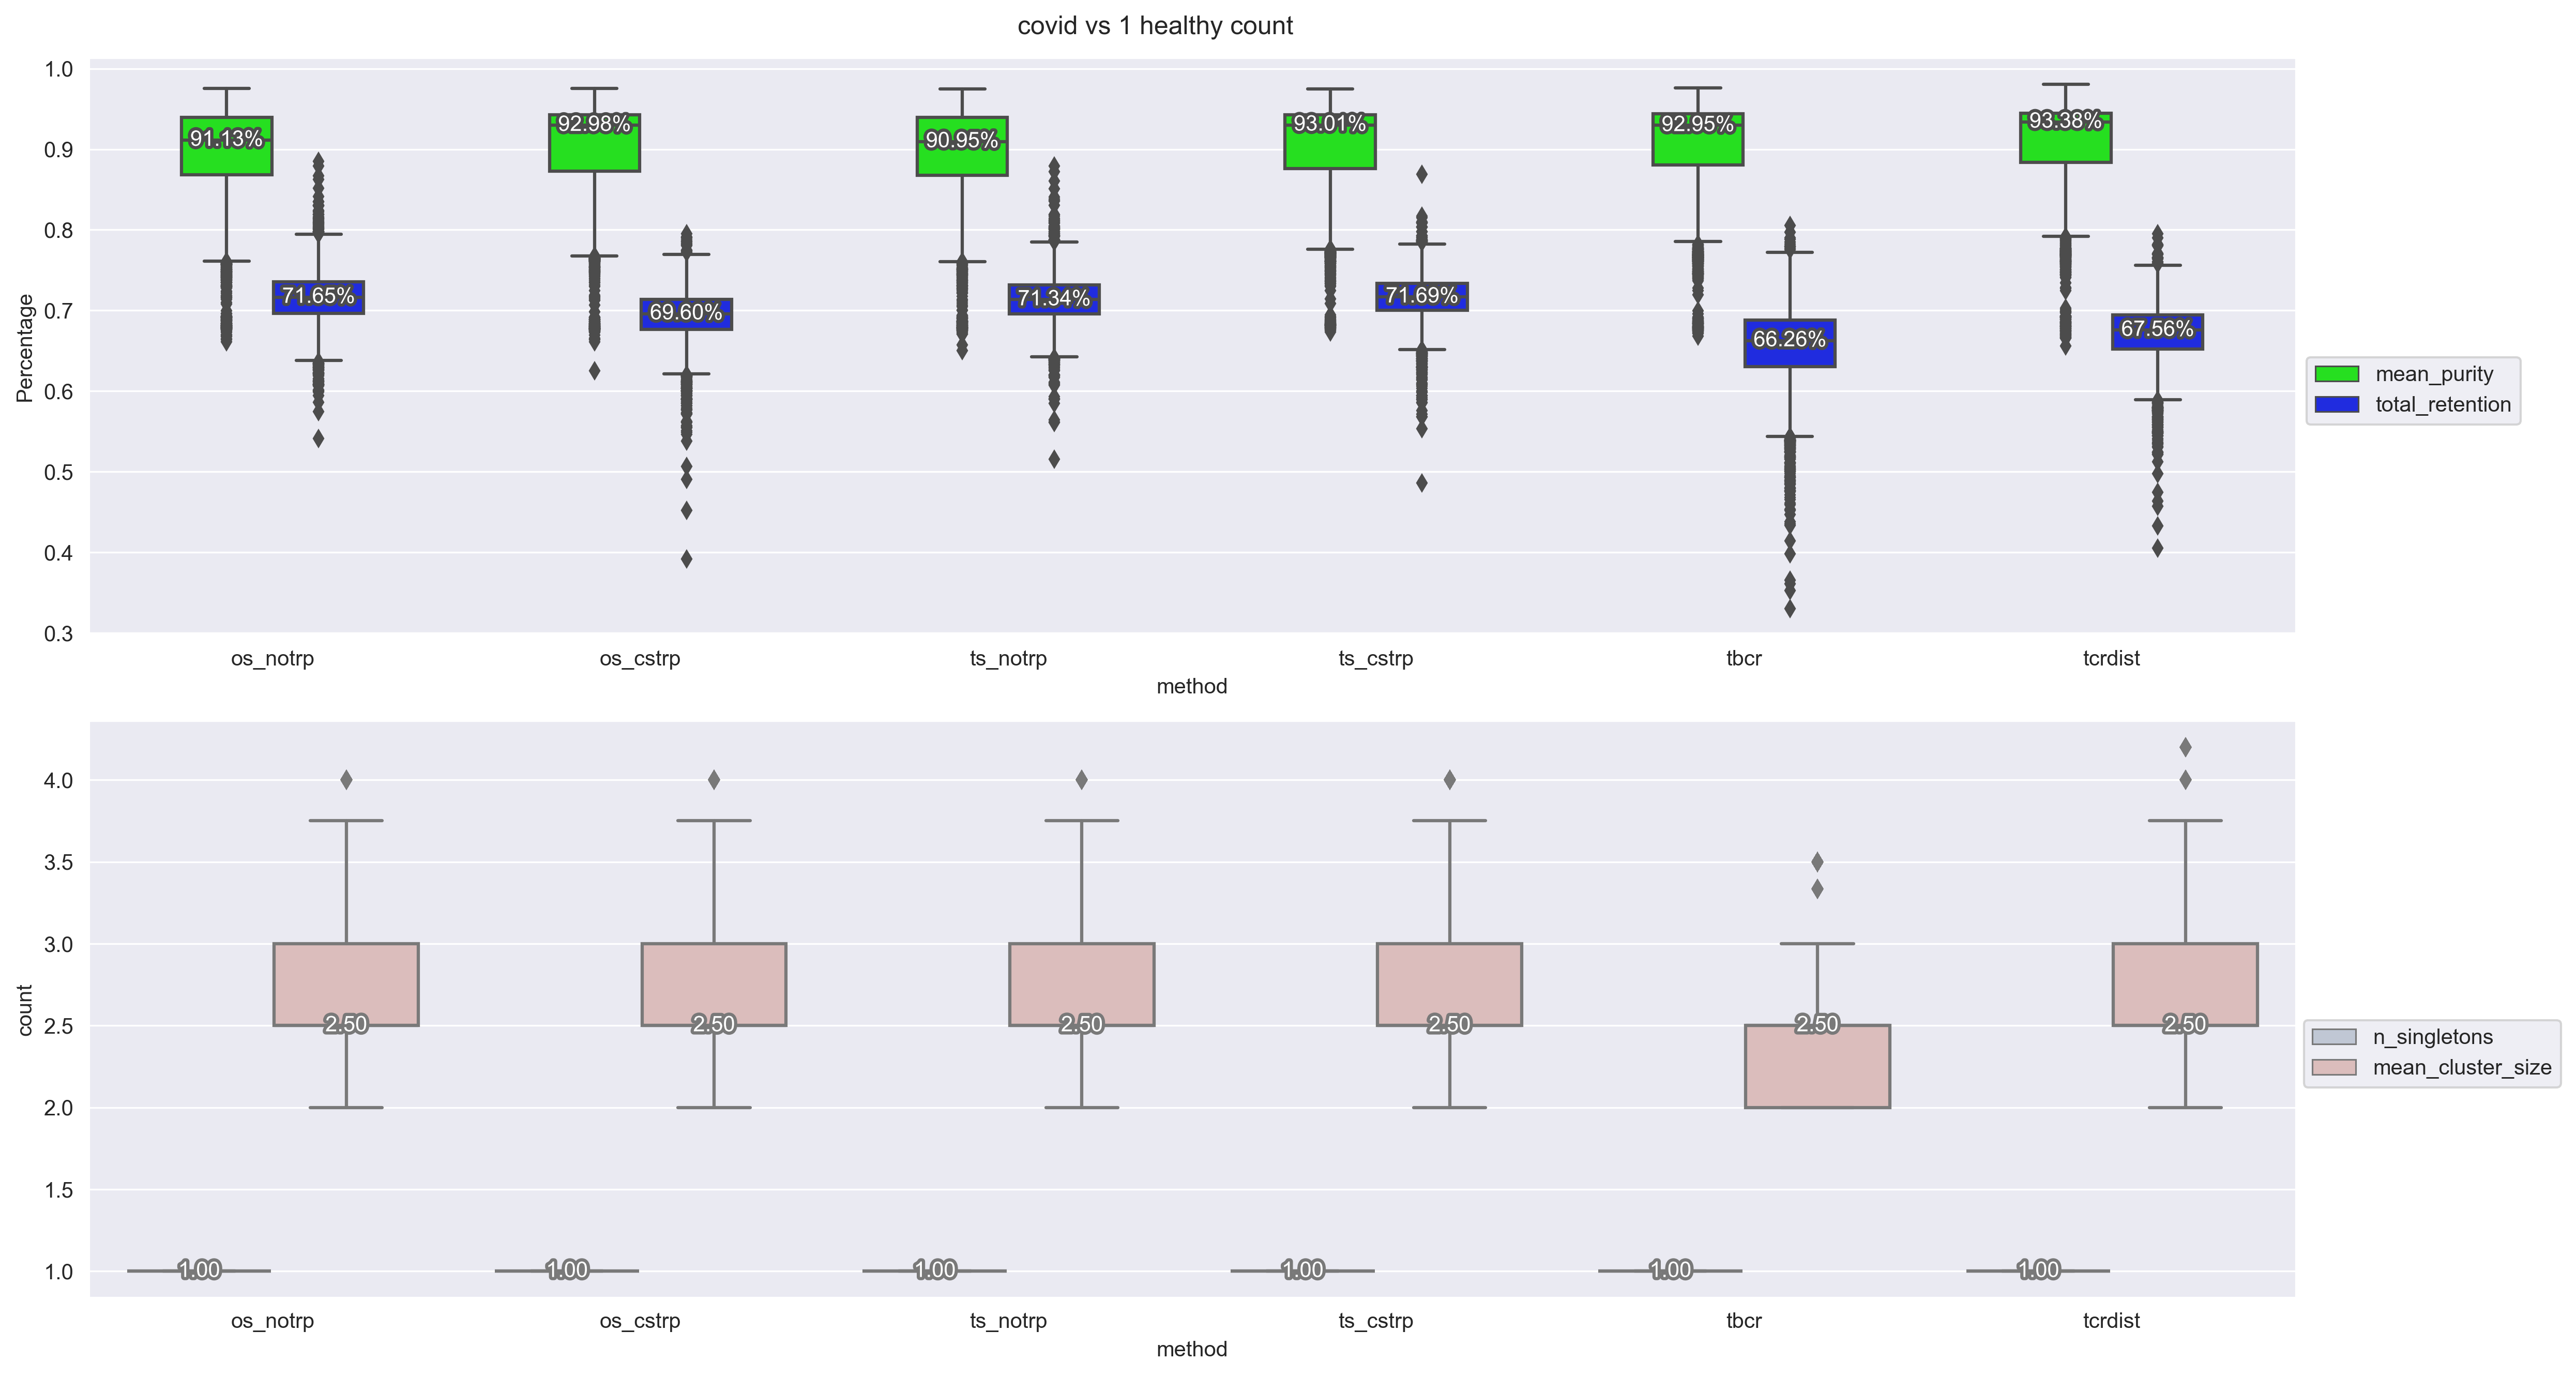

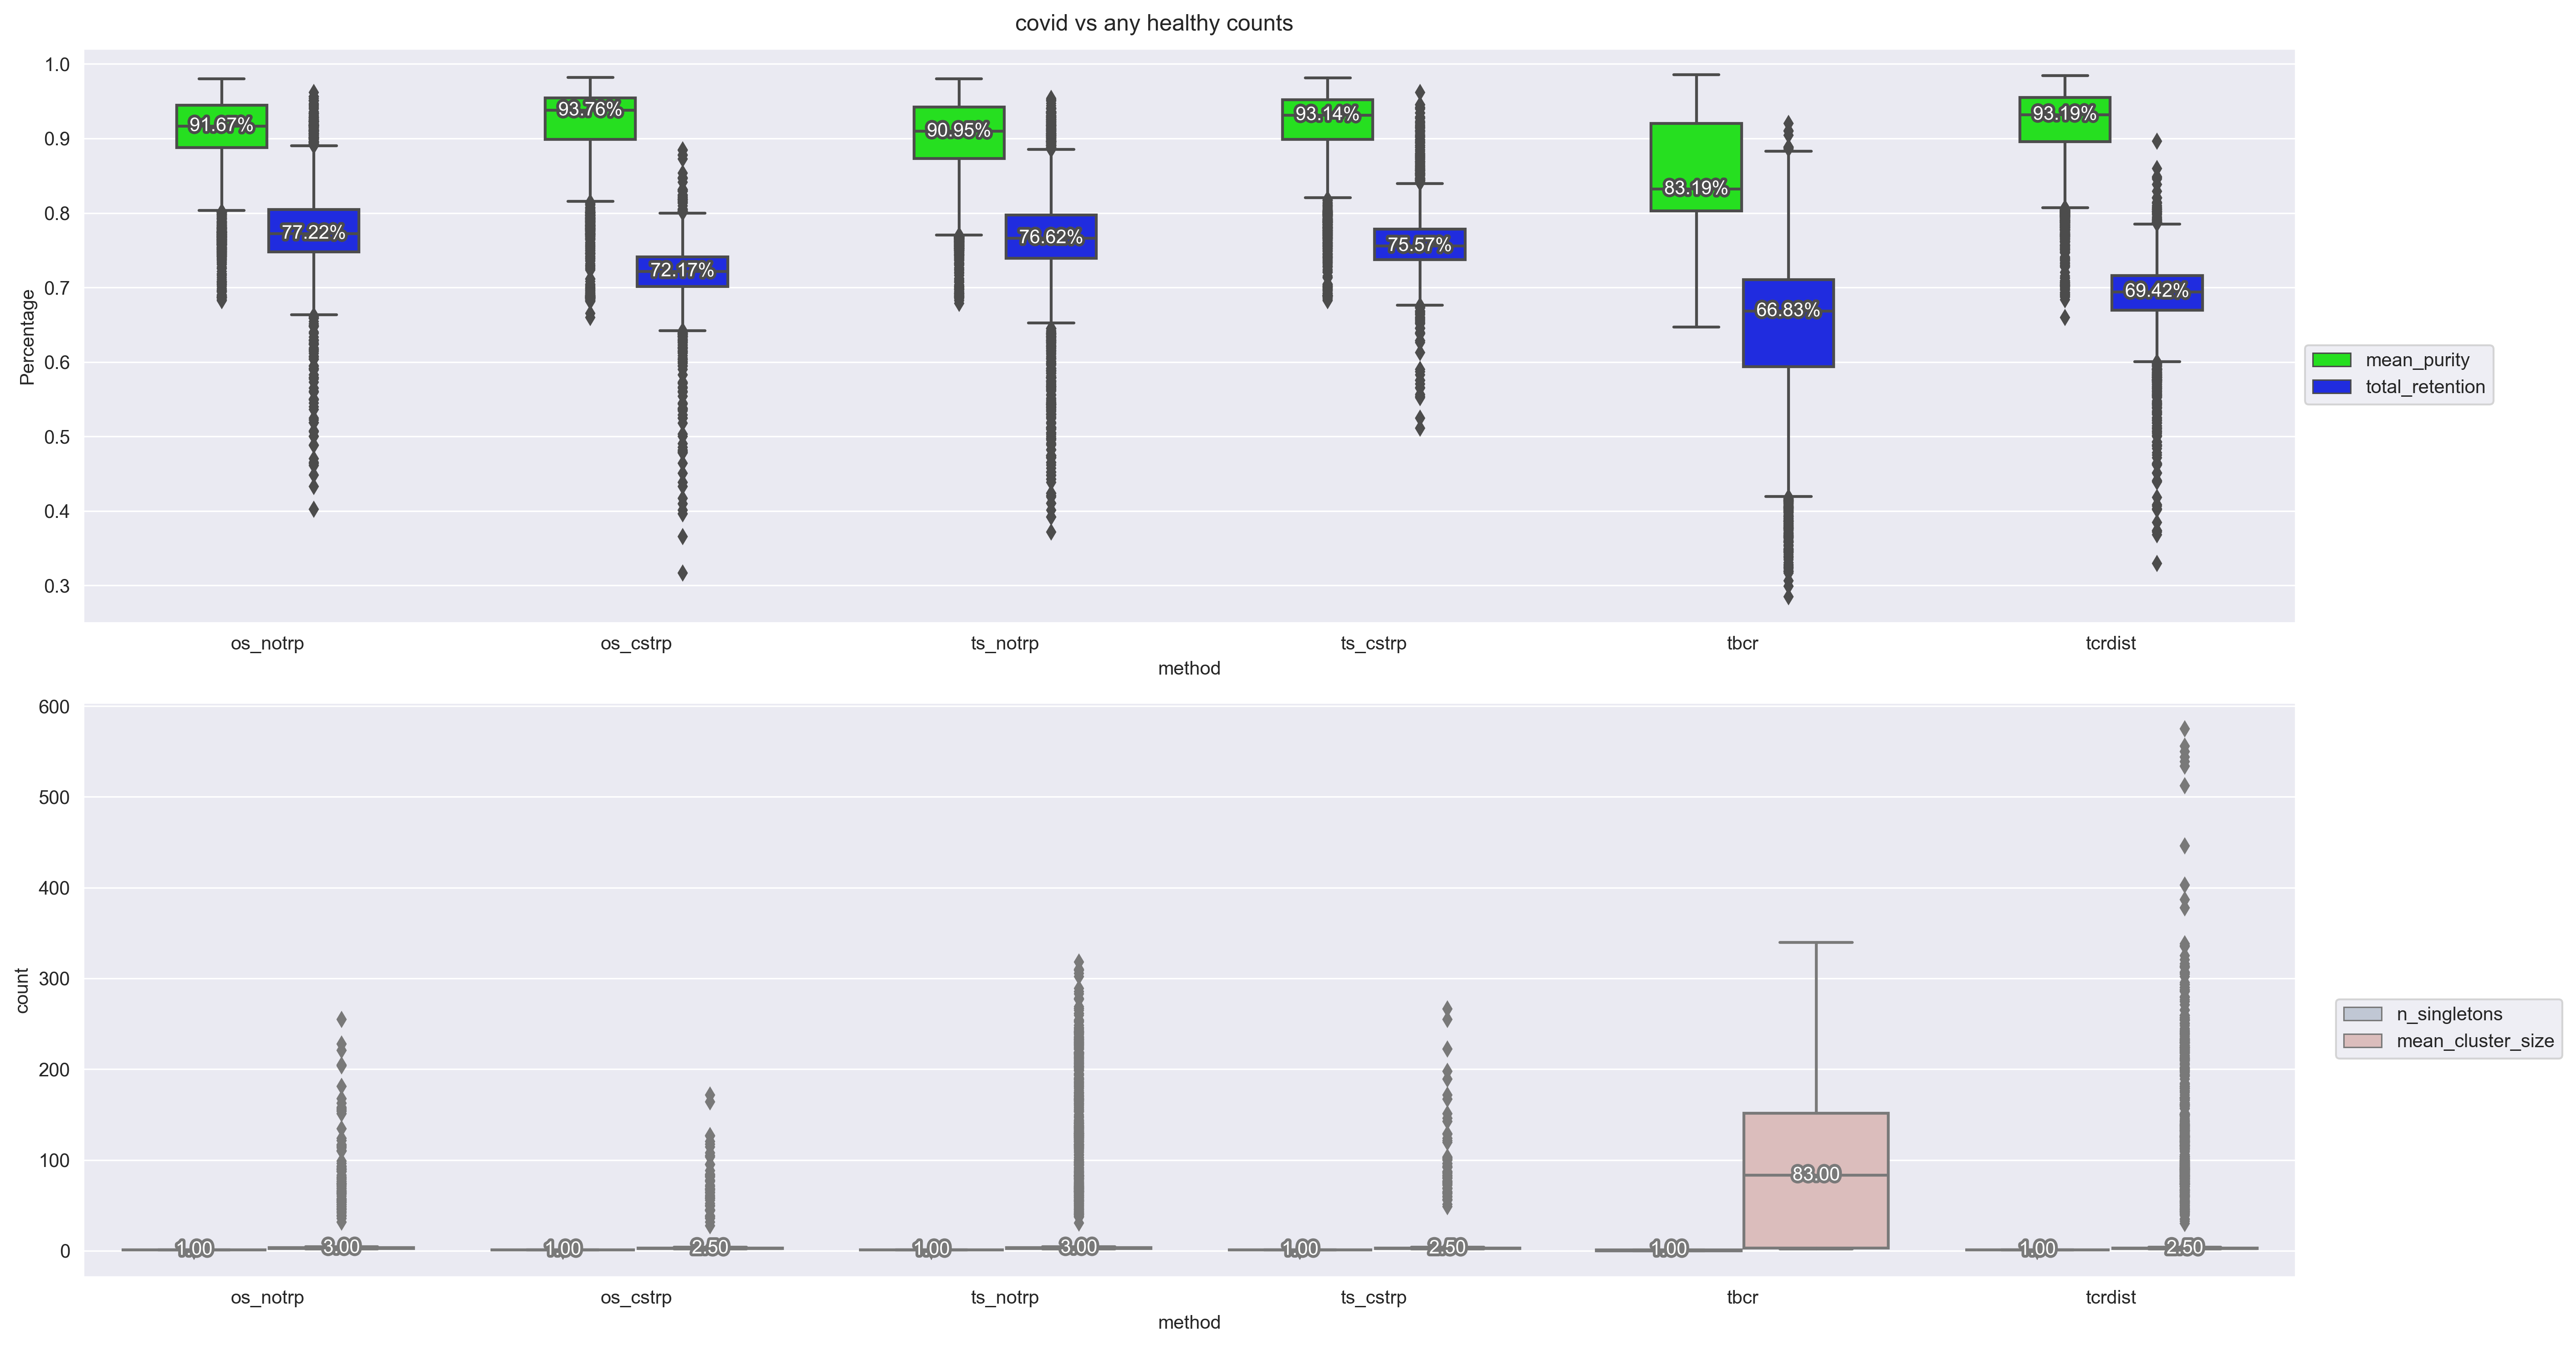

In [183]:
from src.utils import add_median_labels
mpl.rcParams['figure.dpi'] = 300
fig, ax = plt.subplots(2,1, figsize=(15, 9))
ax=ax.ravel()
first_ax=ax[0]
twin_ax=ax[1]
order=['os_notrp', 'os_cstrp', 'ts_notrp', 'ts_cstrp', 'tbcr', 'tcrdist']
percentages = all_cat.melt(id_vars=['method','number', 'seed'], value_vars = ['mean_purity','total_retention'])
melt = all_cat.melt(id_vars=['method','number', 'seed'], value_vars = ['mean_purity','total_retention', 'n_singletons', 'mean_cluster_size'])
numbers = all_cat.melt(id_vars=['method','number', 'seed'], value_vars = ['n_singletons', 'mean_cluster_size'])

sns.boxplot(percentages, x='method', y='value', hue='variable', ax=first_ax, width=0.5, palette='hsv', order=order, dodge=True)
sns.boxplot(numbers, x='method', y='value', hue='variable', ax=twin_ax, width=0.8, palette='vlag', order=order)
add_median_labels(first_ax, fmt='.2%', fontsize=10, fontweight='normal')
add_median_labels(twin_ax, fmt='.2f', fontsize=10, fontweight='normal')
fig.suptitle('covid vs 1 healthy count')
fig.tight_layout()
first_ax.set_ylabel('Percentage')
twin_ax.set_ylabel('count')
first_ax.legend(bbox_to_anchor=(1,.5))
twin_ax.legend(bbox_to_anchor=(1.125,.5))
fig.savefig('../../../writing/VAE_TCR_DRAFT/figures/CovidVsHealthy_LowCount.png', dpi=300, bbox_inches='tight')
from src.utils import add_median_labels
anycat = pd.read_csv('../output/240913_SubsampledFrancisExperiment_all_results/all_cat.csv').query('not method.str.contains("ref") and not (method=="ts_notrp" or method=="ts_cstrp")')
anycat.replace({'ts_cstrp_BL50':'ts_cstrp', 'ts_notrp_BL50':'ts_notrp'}, inplace=True)
mpl.rcParams['figure.dpi'] = 300
fig, ax = plt.subplots(2,1, figsize=(17, 10))
ax=ax.ravel()
first_ax=ax[0]
twin_ax=ax[1]

percentages = anycat.melt(id_vars=['method','number', 'seed'], value_vars = ['mean_purity','total_retention'])
melt = anycat.melt(id_vars=['method','number', 'seed'], value_vars = ['mean_purity','total_retention', 'n_singletons', 'mean_cluster_size'])
numbers = anycat.melt(id_vars=['method','number', 'seed'], value_vars = ['n_singletons', 'mean_cluster_size'])

sns.boxplot(percentages, x='method', y='value', hue='variable', ax=first_ax, width=0.5, palette='hsv', order=order, dodge=True)
sns.boxplot(numbers, x='method', y='value', hue='variable', ax=twin_ax, width=0.8, palette='vlag', order=order)
add_median_labels(first_ax, fmt='.2%', fontsize=10, fontweight='normal')
add_median_labels(twin_ax, fmt='.2f', fontsize=10, fontweight='normal')
fig.suptitle('covid vs any healthy counts')
fig.tight_layout()
first_ax.set_ylabel('Percentage')
twin_ax.set_ylabel('count')
first_ax.legend(bbox_to_anchor=(1,.5))
twin_ax.legend(bbox_to_anchor=(1.125,.5))
fig.savefig('../../../writing/VAE_TCR_DRAFT/figures/CovidVsHealthy_AnyCount.png', dpi=300, bbox_inches='tight')


In [165]:
all_cat['run_id'] = all_cat['number'].astype(str)+'_'+all_cat['seed'].astype(str)
bootstrap_comparisons = do_all_bs_comps(all_cat)
ttest_comparisons = do_all_ttest_comps(all_cat, equal_var=False)
bootstrap_comparisons['sig']= bootstrap_comparisons['pval'].apply(lambda pval: '*' if pval < .05 and pval >= 0.01 else '**' if pval < .01 and pval >= 0.001 
                                                                  else '***' if pval < 0.001 and pval >= 0.0001 else '****' if pval < 0.0001 else 'ns')
ttest_comparisons['sig']= ttest_comparisons['pval'].apply(lambda pval: '*' if pval < .05 and pval >= 0.01 else '**' if pval < .01 and pval >= 0.001 
                                                                  else '***' if pval < 0.001 and pval >= 0.0001 else '****' if pval < 0.0001 else 'ns')
bootstrap_comparisons.to_csv('../output/240913_SubsampledFrancisExperiment_all_results/healthy_lowcount_bootstrap_comparisons.csv', index=False)
ttest_comparisons.to_csv('../output/240913_SubsampledFrancisExperiment_all_results/healthy_lowcount_ttest_comparisons.csv', index=False)

In [166]:
bootstrap_comparisons.query('m_b=="tbcr" and sig !="ns"').sort_values('pval')

,m_a,m_b,pval,var,alt,sig


In [167]:
bootstrap_comparisons.query('m_b=="tcrdist" and sig !="ns"').sort_values('pval')

,m_a,m_b,pval,var,alt,sig


# QVD/KSA/exp_df similarities?

In [48]:
exp_df = pd.read_csv('../data/filtered/240326_nettcr_paired_NOswaps.csv')
train_df = exp_df.query('partition!=0 and partition!=1')
cancer = pd.concat([pd.read_csv(x) for x in glob.glob('../data/OTS/eberhardt_cancer/*.txt')])
cancer['peptide'] = cancer['TSubtype'].apply(lambda x: 'QVD' if 'qvd' in x.lower() else 'KSA')
cancer.head()

,tcr,v_beta,d_beta,j_beta,B1,B2,B3,v_alpha,d_alpha,j_alpha,...,Link,Disease,CancerType,Source,Subject,count,Run,TSubtype,index_col,peptide
0,YGATPYYFSGDTLVAVGATLTGNQFYSEHNRFQNEAQASSPGGETG...,TRBV7-9*03,TRBD1*01,TRBJ2-3*01,SEHNR,FQNEAQ,ASSPGGETGGIEDTQY,TRAV8-3*01,NaN,TRAJ49*01,...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,tumor,hpv51,4,SRR15178231,tetramer_ksa,hpv51_ksa_000,KSA
1,TSESDYYQEAYKQQNAYRSAGAQKLVMGHRAYSYEKLASSLEGRDL...,TRBV4-1*01,TRBD1*01,TRBJ2-1*01,MGHRA,YSYEKL,ASSLEGRDLIFEQF,TRAV38-2/DV8*01,NaN,TRAJ54*01,...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,tumor,hpv51,5,SRR15178231,tetramer_ksa,hpv51_ksa_001,KSA
2,SSYSPSYTSAATLVVVSDRNSAGNKLTSEHNRFQNEAQASSSQTSG...,TRBV7-9*03,TRBD2*01,TRBJ2-5*01,SEHNR,FQNEAQ,ASSSQTSGGGETQY,TRAV8-2*01,NaN,TRAJ17*01,...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,tumor,hpv51,1,SRR15178231,tetramer_ksa,hpv51_ksa_002,KSA
3,SIFNTLYKAGELAGQLRGSGNTPLVSGHTAFQGTGAASSLGTSMDTQY,TRBV7-3*01,TRBD2*01,TRBJ2-3*01,SGHTA,FQGTGA,ASSLGTSMDTQY,TRAV35*01,NaN,TRAJ29*01,...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,tumor,hpv51,1,SRR15178233,tetramer_ksa,hpv51_ksa_003,KSA
4,YGATPYYFSGDTLVAVGVTLTGNQFYSEHNRFQNEAQASSPGGETG...,TRBV7-9*03,TRBD1*01,TRBJ2-3*01,SEHNR,FQNEAQ,ASSPGGETGGIEDTQY,TRAV8-3*01,NaN,TRAJ49*01,...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,tumor,hpv51,1,SRR15178233,tetramer_ksa,hpv51_ksa_004,KSA


In [190]:
covid = pd.concat([pd.read_csv(x) for x in glob.glob('../data/OTS/francis_covid_042/*')])

,Unnamed: 0,tcr,v_beta,d_beta,j_beta,B1,B2,B3,v_alpha,d_alpha,...,A2,A3,Link,Disease,CancerType,Source,Subject,count,Run,index_col
2,2,TSGFNGNVLDGLAVLRRGDYKLSSGHNSFNNNVPASTSGTGATNYGYT,TRBV12-3*01,TRBD1*01,TRBJ1-2*01,SGHNS,FNNNVP,ASTSGTGATNYGYT,TRAV1-2*01,NaN,...,NVLDGL,AVLRRGDYKLS,https://pubmed.ncbi.nlm.nih.gov/34793243/,covid,none,pbmc,no,6,SRR16868549,francis_0002
3,3,DRGSQSIYSNGDAVGTGGFKTIMDHENSYDVKMASSRQGLGQPQH,TRBV28*01,TRBD1*01,TRBJ1-5*01,MDHEN,SYDVKM,ASSRQGLGQPQH,TRAV12-2*01,NaN,...,IYSNGD,AVGTGGFKTI,https://pubmed.ncbi.nlm.nih.gov/34793243/,covid,none,pbmc,no,20,SRR16868549,francis_0003
6,6,TSGFNGNVLDGLAVPGGATNKLISGDLSYYNGEEASSVGQGTYEQY,TRBV9*01,TRBD1*01,TRBJ2-7*01,SGDLS,YYNGEE,ASSVGQGTYEQY,TRAV1-2*01,NaN,...,NVLDGL,AVPGGATNKLI,https://pubmed.ncbi.nlm.nih.gov/34793243/,covid,none,pbmc,no,4,SRR16868549,francis_0006
10,10,ATGYPSATKADDKALSDAGGSYIPTMNHNYSVGAGIASLGGDTQY,TRBV6-6*02,NaN,TRBJ2-3*01,MNHNY,SVGAGI,ASLGGDTQY,TRAV9-2*02,NaN,...,ATKADDK,ALSDAGGSYIPT,https://pubmed.ncbi.nlm.nih.gov/34793243/,covid,none,pbmc,no,6,SRR16868549,francis_0010
11,11,DRGSQSIYSNGDAVNTGGFKTIDFQATTSNEGSKASVDPGGSHEQY,TRBV20-1*01,TRBD1*01,TRBJ2-7*01,DFQATT,SNEGSKA,SVDPGGSHEQY,TRAV12-2*01,NaN,...,IYSNGD,AVNTGGFKTI,https://pubmed.ncbi.nlm.nih.gov/34793243/,covid,none,pbmc,no,27,SRR16868549,francis_0011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54,54,NSMFDYISSIKDKAASAGSMRMNHNYSVGAGIASSYSEGQGWHT,TRBV6-6*01,TRBD1*01,TRBJ1-2*01,MNHNY,SVGAGI,ASSYSEGQGWHT,TRAV29/DV5*04,NaN,...,ISSIKDK,AASAGSMR,https://pubmed.ncbi.nlm.nih.gov/34793243/,covid,none,pbmc,no,2,SRR16868548,francis_0054
64,64,VSGLRGLYSAGEEAVQAWGNNRLAMGHRAYSYEKLASSQEGDRVPP...,TRBV4-1*01,TRBD1*01,TRBJ2-7*01,MGHRA,YSYEKL,ASSQEGDRVPPLYEQY,TRAV20*02,NaN,...,LYSAGEE,AVQAWGNNRLA,https://pubmed.ncbi.nlm.nih.gov/34793243/,covid,none,pbmc,no,2,SRR16868548,francis_0064
84,84,NSMFDYISSIKDKAASERNRDDKIIMGHRAYSYEKLASSQERLSLSPLH,TRBV4-1*01,NaN,TRBJ1-6*02,MGHRA,YSYEKL,ASSQERLSLSPLH,TRAV29/DV5*04,NaN,...,ISSIKDK,AASERNRDDKII,https://pubmed.ncbi.nlm.nih.gov/34793243/,covid,none,pbmc,no,2,SRR16868548,francis_0084
102,102,SSNFYAMTLNGDEASSLRGATNKLISGHNSFNNNVPASSLGPGFQPQH,TRBV12-3*01,TRBD2*01,TRBJ1-5*01,SGHNS,FNNNVP,ASSLGPGFQPQH,TRAV24*01,NaN,...,MTLNGDE,ASSLRGATNKLI,https://pubmed.ncbi.nlm.nih.gov/34793243/,covid,none,pbmc,no,2,SRR16868548,francis_0102


In [51]:
pd.concat([cancer.assign(dataset='cancer_mixed', partition=-1), 
           train_df.assign(dataset='exp_train', TSubtype='train',
                           Run='nettcr_exp').rename(columns={'raw_index':'index_col'}),
           covid.drop_duplicates('tcr').query('count>=2').assign(dataset='covi]).to_csv('../data/OTS/cancer_train_mixed.csv')


In [54]:
dm = pd.read_csv('../data/OTS/cancer_train_mixed_TBCR_distmatrix.csv', index_col=0)
dm

,0,1,2,3,4,5,6,7,8,9,...,6017,6018,6019,6020,6021,peptide,Run,index_col,TSubtype,dataset
q_index,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.207734,0.147773,0.189828,0.009479,0.203837,0.184994,0.176461,0.200627,0.187541,...,0.216445,0.203983,0.173823,0.222485,0.178605,KSA,SRR15178231,hpv51_ksa_000,tetramer_ksa,cancer_mixed
1,0.207734,0.000000,0.196881,0.180998,0.214543,0.193051,0.189451,0.192982,0.189236,0.181932,...,0.170789,0.192680,0.197005,0.219683,0.171794,KSA,SRR15178231,hpv51_ksa_001,tetramer_ksa,cancer_mixed
2,0.147773,0.196881,0.000000,0.170280,0.151554,0.195785,0.173771,0.173792,0.187968,0.182559,...,0.178108,0.176293,0.169452,0.207566,0.162432,KSA,SRR15178231,hpv51_ksa_002,tetramer_ksa,cancer_mixed
3,0.189828,0.180998,0.170280,0.000000,0.193811,0.204426,0.185849,0.166361,0.178042,0.182832,...,0.167613,0.163080,0.191929,0.198881,0.171072,KSA,SRR15178233,hpv51_ksa_003,tetramer_ksa,cancer_mixed
4,0.009479,0.214543,0.151554,0.193811,0.000000,0.201933,0.186653,0.181743,0.205868,0.189201,...,0.222846,0.210897,0.173294,0.222867,0.180985,KSA,SRR15178233,hpv51_ksa_004,tetramer_ksa,cancer_mixed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6017,0.216445,0.170789,0.178108,0.167613,0.222846,0.214851,0.164112,0.202003,0.141792,0.155516,...,0.000000,0.169166,0.210006,0.217445,0.192339,KLGGALQAK,nettcr_exp,ITRAP_1374,train,exp_train
6018,0.203983,0.192680,0.176293,0.163080,0.210897,0.211776,0.169244,0.197798,0.170159,0.165005,...,0.169166,0.000000,0.206359,0.205467,0.187689,KLGGALQAK,nettcr_exp,ITRAP_3187,train,exp_train
6019,0.173823,0.197005,0.169452,0.191929,0.173294,0.185021,0.158692,0.190448,0.180639,0.175123,...,0.210006,0.206359,0.000000,0.225351,0.160969,NLVPMVATV,nettcr_exp,VDJdb_6082,train,exp_train


In [70]:
query = dm.query('dataset=="cancer_mixed"')
database = dm.query('dataset!="cancer_mixed"')
query.drop(columns=[str(x) for x in query.index], inplace=True)
ksa = query.query('peptide=="KSA"')
qvd = query.query('peptide=="QVD"')
rest_cols = ['peptide','Run', 'index_col', 'TSubtype','dataset']


In [132]:
tmp = database.drop(columns = [x for x in database.columns if x.isnumeric() and int(x) not in database.index])
tmp.replace(0,10, inplace=True)
tmp['match']=tmp[[x for x in tmp.columns if x.isnumeric()]].idxmin(axis=1)
qvd['match']=qvd[[x for x in qvd.columns if x.isnumeric()]].idxmin(axis=1)
ksa['match']=ksa[[x for x in ksa.columns if x.isnumeric()]].idxmin(axis=1)
tmp['matched_pep'] = tmp['match'].apply(lambda x: database.loc[int(x)]['peptide'])
qvd['matched_pep'] = qvd['match'].apply(lambda x: database.loc[int(x)]['peptide'])
ksa['matched_pep'] = ksa['match'].apply(lambda x: database.loc[int(x)]['peptide'])
tmp['matched_score'] = tmp[[x for x in tmp.columns if x.isnumeric()]].min(axis=1)
qvd['matched_score'] = qvd[[x for x in qvd.columns if x.isnumeric()]].min(axis=1)
ksa['matched_score'] = ksa[[x for x in ksa.columns if x.isnumeric()]].min(axis=1)

In [145]:
top17peps=pd.read_csv('../data/filtered/240418_nettcr_expanded_20binders_17pep_POSONLY.csv').peptide.unique()
tmp.query('peptide in @top17peps').groupby(['peptide','matched_pep']).agg(count=('Run','count'))

count
peptide   matched_pep        
ATDALMTGF AAFKRSCLK         1
          ALYGFVPVL         1
          ATDALMTGF        29
          AVFDRKSDAK        3
          DATYQRTRALVR      1
...                       ...
YLQPRTFLL VLFGLGFAI         2
          VVMSWAPPV         2
          VYFLQSINF         1
          YLQPRTFLL       110
          YVLDHLIVV         1

[685 rows x 1 columns]

In [127]:
display(qvd.groupby('matched_pep').agg(count=('Run','count')).sort_values('count',ascending=False))
display(ksa.groupby('matched_pep').agg(count=('Run','count')).sort_values('count',ascending=False))

,count
matched_pep,
TTDPSFLGRY,28
KLGGALQAK,14
GILGFVFTL,13
VYGIRLEHF,7
RAKFKQLL,6
AVFDRKSDAK,5
YLQPRTFLL,4
FLYALALLL,4
NLVPMVATV,4


,count
matched_pep,
GILGFVFTL,21
RAKFKQLL,5
KLGGALQAK,3
CLAVHECFV,3
AVFDRKSDAK,3
ATDALMTGF,2
SPRWYFYYL,2
VFLVLLPLV,2
GLCTLVAML,2


Text(0.5, 1.0, 'Total score distribution (X vs "train")')

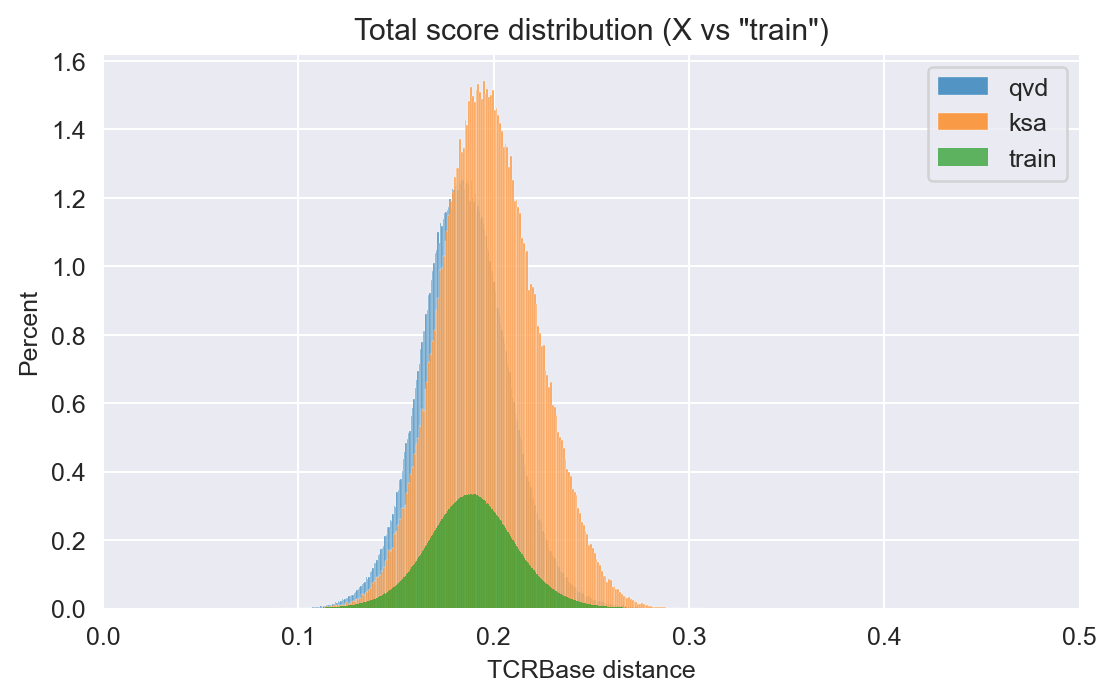

In [137]:
fig,ax = plt.subplots(1,1, figsize=(7,4))
tmp_values = tmp.iloc[:len(tmp), :len(tmp)].values.flatten()
sns.histplot(qvd[[x for x in qvd.columns if x.isnumeric()]].values.flatten(), ax=ax, label='qvd', stat='percent')
sns.histplot(ksa[[x for x in ksa.columns if x.isnumeric()]].values.flatten(), ax=ax, label='ksa', stat='percent')
sns.histplot(tmp_values[tmp_values!=0], label='train', ax=ax, stat='percent')
ax.legend()
ax.set_xlabel('TCRBase distance')
ax.set_xlim([0,0.5])
ax.set_title('Total score distribution (X vs "train")')

Text(0.5, 1.0, 'Best score distribution (X vs "train")')

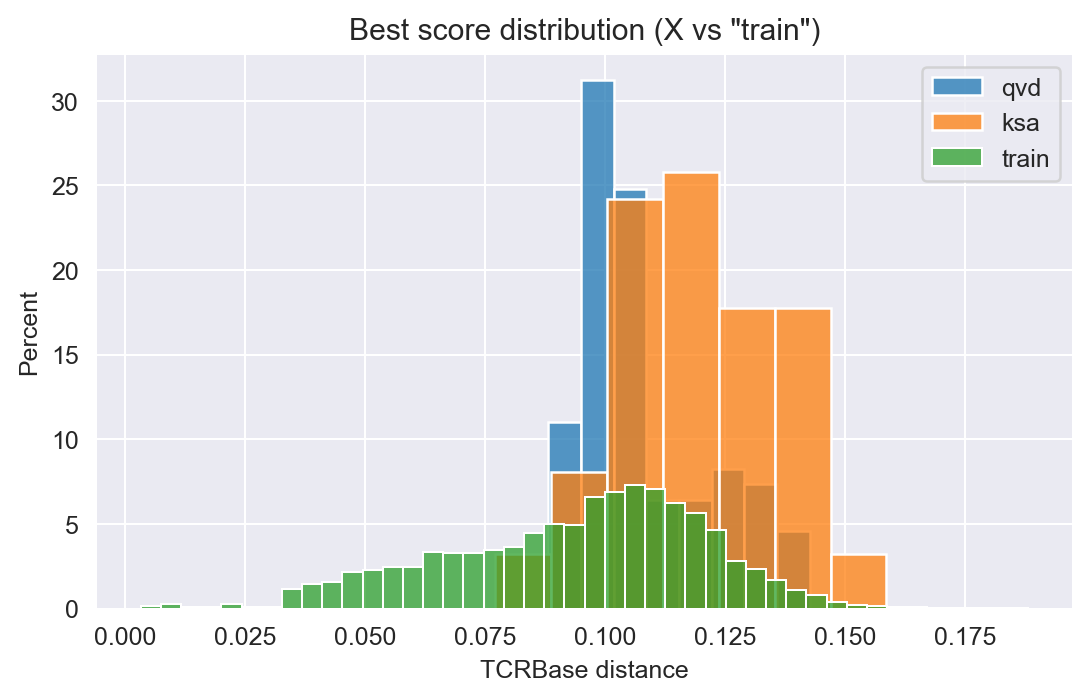

In [138]:
fig,ax = plt.subplots(1,1, figsize=(7,4))
sns.histplot(qvd['matched_score'].values.flatten(), ax=ax, label='qvd', stat='percent')
sns.histplot(ksa['matched_score'].values.flatten(), ax=ax, label='ksa', stat='percent')
sns.histplot(tmp['matched_score'].values.flatten(), label='train', ax=ax, stat='percent')
ax.legend()
ax.set_xlabel('TCRBase distance')
ax.set_title('Best score distribution (X vs "train")')